In [193]:
!pip install aif360
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from collections import OrderedDict
import shutil
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB

from aif360.datasets import BinaryLabelDataset, CompasDataset

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_compas
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [194]:
def compute_metrics(true_ds, pred_ds, non_privileged, privileged, disp = True):
    pred_classify_metric = ClassificationMetric(true_ds,
                                                 pred_ds, 
                                                 unprivileged_groups=non_privileged,
                                                 privileged_groups=privileged)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(pred_classify_metric.true_positive_rate()+
                                             pred_classify_metric.true_negative_rate())
    metrics["Statistical parity difference"] = pred_classify_metric.statistical_parity_difference()
    metrics["Disparate impact"] = pred_classify_metric.disparate_impact()
    metrics["Average odds difference"] = pred_classify_metric.average_odds_difference()
    metrics["Equal opportunity difference"] = pred_classify_metric.equal_opportunity_difference()
    metrics["Theil index"] = pred_classify_metric.theil_index()

    if disp == True:
        for key, value in metrics.items():
            print(str(key) +" = "+ str(value))

    return metrics

In [195]:
original = r'/content/compas-scores-two-years.csv'
target = r'/usr/local/lib/python3.8/dist-packages/aif360/data/raw/compas'

shutil.copy(original,target)

'/usr/local/lib/python3.8/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv'

In [196]:
privileged_grp = [{'race': 1}]
nonprivileged_grp  = [{'race': 0}]
orig_set = load_preproc_data_compas(['race'])

metric_add =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
np.random.seed(1)

In [197]:
train_dataset_orig, validate_dataset_orig = orig_set.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = validate_dataset_orig.split([0.5], shuffle=True)

In [198]:
print("shape of training set: ", train_dataset_orig.features.shape  )
print("Favorable labels: ",train_dataset_orig.favorable_label)
print("Unfavorable labels: ",train_dataset_orig.unfavorable_label)
print("bias attributes: ", train_dataset_orig.protected_attribute_names)
print("Dataset feature names:", train_dataset_orig.feature_names)

shape of training set:  (3694, 10)
Favorable labels:  0.0
Unfavorable labels:  1.0
bias attributes:  ['race']
Dataset feature names: ['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


Metric for original training data

In [199]:
original_train_metric = BinaryLabelDatasetMetric(train_dataset_orig, 
                                             unprivileged_groups=nonprivileged_grp ,
                                             privileged_groups=privileged_grp)
print("Original training dataset")
print("Difference in mean outcomes of nonprivileged and privileged = ", float(round(original_train_metric.mean_difference(),5)))

Original training dataset
Difference in mean outcomes of nonprivileged and privileged =  -0.12709


Train with and transform the original training data

In [200]:
Reweigh_preproc = Reweighing(unprivileged_groups=nonprivileged_grp ,
               privileged_groups=privileged_grp)
Reweigh_preproc.fit(train_dataset_orig)
transform_train_data = Reweigh_preproc.transform(train_dataset_orig)

Metric with the transformed training data

In [201]:
transform_train_metric = BinaryLabelDatasetMetric(transform_train_data, 
                                         unprivileged_groups=nonprivileged_grp ,
                                         privileged_groups=privileged_grp)
print("Transformed training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = ", float(round(transform_train_metric.mean_difference(),4)))

Transformed training dataset
Difference in mean outcomes between unprivileged and privileged groups =  0.0


Train classifier on original data

In [202]:
original_datascaling = StandardScaler()
def scaling(ds):
    X_train = original_datascaling.fit_transform(ds.features)
    y_train = ds.labels.ravel()
    wgt_train = ds.instance_weights.ravel()
    return X_train, y_train, wgt_train

def RandomForest(a, b, c):
    clf = RandomForestClassifier()
    clf.fit(a, b, sample_weight=c.instance_weights)
    return clf

def NaiveBayes(a, b):
    classifier = GaussianNB()
    classifier.fit(a, b)
    return classifier

def Linear_SVC (a,b):
    linear_svc = SVC() 
    clf = linear_svc.fit(a, b)
    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(a,b)
    return model

X_train, y_train, wgt_train = scaling(train_dataset_orig)
classifier_model = RandomForest(X_train, y_train, train_dataset_orig)
y_train_pred = classifier_model.predict(X_train)


Obtain scores for original validation and test sets

In [203]:
pos_class_ind = np.where(classifier_model.classes_ == train_dataset_orig.favorable_label)[0][0]
orig_train_pred_set = train_dataset_orig.copy()
orig_train_pred_set.labels = y_train_pred

orig_valid_pred_set = dataset_orig_valid.copy(deepcopy=True)
X_valid = original_datascaling.transform(orig_valid_pred_set.features)
y_valid = orig_valid_pred_set.labels
orig_valid_pred_set.scores = classifier_model.predict_proba(X_valid)[:,pos_class_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = original_datascaling.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = classifier_model.predict_proba(X_test)[:,pos_class_ind].reshape(-1,1)

Find the optimal classification threshold from the validation set

In [204]:
threshold_count = 100
bal_acc = []
class_thresh_array = np.linspace(0.01, 0.99, threshold_count)
def threshold_classification(class_thresh_arr, dataset_orig_valid, valid_pred_dataset, unpvg, pvg, balanced_accuracy):
    for class_thresh in class_thresh_arr:
        fav_inds = valid_pred_dataset.scores > class_thresh
        valid_pred_dataset.labels[fav_inds] = valid_pred_dataset.favorable_label
        valid_pred_dataset.labels[~fav_inds] = valid_pred_dataset.unfavorable_label
        
        classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,valid_pred_dataset, 
                                                unprivileged_groups=unpvg,
                                                privileged_groups=pvg)
        averaging_rates = (classified_metric_orig_valid.true_positive_rate()+classified_metric_orig_valid.true_negative_rate())/2
        balanced_accuracy.append(averaging_rates)
    
    filter = (balanced_accuracy == np.max(balanced_accuracy))
    y = class_thresh_arr[np.where(filter)[0][0]]
    return y, balanced_accuracy

best_thresh, bal_acc = threshold_classification(class_thresh_array, dataset_orig_valid, orig_valid_pred_set, nonprivileged_grp, privileged_grp, bal_acc)

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(bal_acc))
print("Optimal classification threshold (no reweighing) = %.4f" % best_thresh)

Best balanced accuracy (no reweighing) = 0.6475
Optimal classification threshold (no reweighing) = 0.5247


Predictions from the original test set at the optimal classification threshold

In [205]:
print("Predictions from original testing data")
orig_bal_acc_arr = []
orig_disp_imp_arr = []
orig_avg_odds_diff_arr = []

print("Classification threshold used = %.4f" % best_thresh)
def optimal_classification(original_test_dataset,orig_test_prediction, x, y, z, class_thresh_array, upgrp, pgrp, best_class_threshold):
    for thresh in class_thresh_array:
        if thresh == best_class_threshold:
            flag = True
        else:
            flag = False
        valued_indices = orig_test_prediction.scores > thresh
        orig_test_prediction.labels[valued_indices] = orig_test_prediction.favorable_label
        orig_test_prediction.labels[~valued_indices] = orig_test_prediction.unfavorable_label
        
        before_test_metric = compute_metrics(original_test_dataset, orig_test_prediction, upgrp, pgrp, disp = flag)

        x.append(before_test_metric["Balanced accuracy"])
        y.append(before_test_metric["Disparate impact"])
        z.append(before_test_metric["Average odds difference"])
    return x, y, z


orig_bal_acc_arr, orig_disp_imp_arr, orig_avg_odds_diff_arr = optimal_classification(dataset_orig_test, dataset_orig_test_pred, orig_bal_acc_arr, orig_disp_imp_arr, 
                           orig_avg_odds_diff_arr, class_thresh_array, nonprivileged_grp, privileged_grp , best_thresh)

Predictions from original testing data
Classification threshold used = 0.5247
Balanced accuracy = 0.6598557462358186
Statistical parity difference = -0.1452941605307283
Disparate impact = 0.7883614739301263
Average odds difference = -0.09015600048046016
Equal opportunity difference = -0.11124067164179108
Theil index = 0.1806432673683878


/usr/local/lib/python3.8/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [206]:
thresh = best_thresh
valued_indices = dataset_orig_test_pred.scores > thresh
dataset_orig_test_pred.labels[valued_indices] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~valued_indices] = dataset_orig_test_pred.unfavorable_label
before_metric = compute_metrics(dataset_orig_test, dataset_orig_test_pred, nonprivileged_grp, privileged_grp, disp = True)

Balanced accuracy = 0.6598557462358186
Statistical parity difference = -0.1452941605307283
Disparate impact = 0.7883614739301263
Average odds difference = -0.09015600048046016
Equal opportunity difference = -0.11124067164179108
Theil index = 0.1806432673683878


Display results for all thresholds

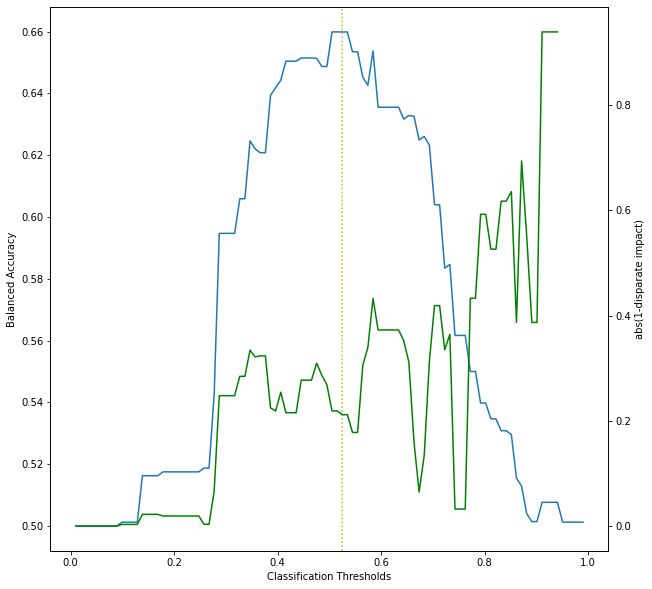

In [207]:
def line_graph_accuracy_disparate_impact(a,b,c,d):
    fig, ax = plt.subplots(figsize=(10, 10))
    p = sns.lineplot(a, b)
    p.set_xlabel('Classification Thresholds')
    p.set_ylabel('Balanced Accuracy')
    p.axvline(d, color='y', linestyle=':')
    p1 = p.twinx()
    p1 = sns.lineplot(a, c, color='green')
    p1.set_ylabel('abs(1-disparate impact)')

line_graph_accuracy_disparate_impact(class_thresh_array, orig_bal_acc_arr, np.abs(1.0-np.array(orig_disp_imp_arr)), best_thresh)

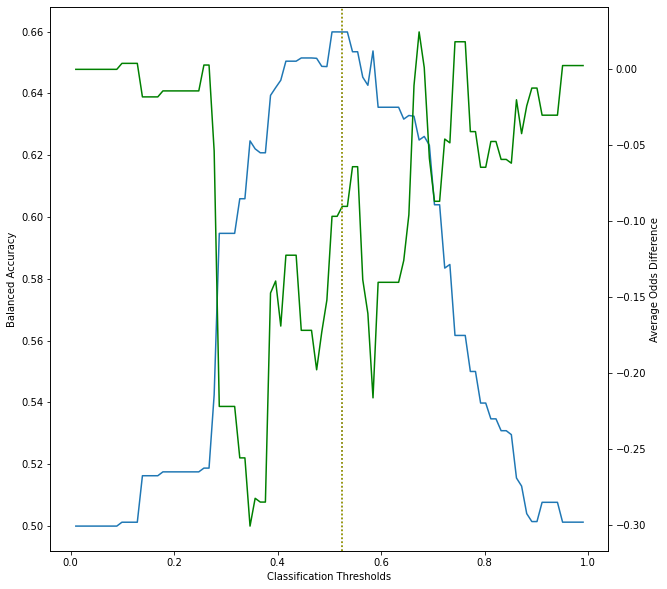

In [208]:
def line_graph_accuracy_aod(a,b,c,d):
    fig, ax = plt.subplots(figsize=(10, 10))
    p = sns.lineplot(a, b)
    p.set_xlabel('Classification Thresholds')
    p.set_ylabel('Balanced Accuracy')
    p.axvline(d, color='k', linestyle=':')
    p1 = p.twinx()
    p1 = sns.lineplot(a, c,color='green')
    p1.set_ylabel('Average Odds Difference')
    p1.axvline(d, color='y', linestyle=':')

line_graph_accuracy_aod(class_thresh_array, orig_bal_acc_arr, orig_avg_odds_diff_arr, best_thresh)

Train classifier on transformed data

In [209]:
transform_scaling = StandardScaler()
def scaling_trasformation(ds):
    X_train = transform_scaling.fit_transform(ds.features)
    y_train = ds.labels.ravel()
    return X_train, y_train

X_train, y_train = scaling_trasformation(transform_train_data)
classifier_transform = RandomForest(X_train, y_train, transform_train_data)
y_train_pred = classifier_transform.predict(X_train)

Obtain scores for transformed test set

In [210]:
transf_test_pred_set= dataset_orig_test.copy(deepcopy=True)
X_test = transform_scaling.fit_transform(transf_test_pred_set.features)
y_test = transf_test_pred_set.labels
transf_test_pred_set.scores = classifier_transform.predict_proba(X_test)[:,pos_class_ind].reshape(-1,1)

Predictions from the transformed test set at the optimal classification threshold

In [211]:
print("Predictions from transformed testing data")
transform_bal_acc_arr = []
transform_disp_imp_arr = []
transform_avg_odds_diff_arr = []

print("Classification threshold used = ", float(round(best_thresh,4)))

transform_bal_acc_arr, transform_disp_imp_arr, transform_avg_odds_diff_arr = optimal_classification(dataset_orig_test, transf_test_pred_set, transform_bal_acc_arr, transform_avg_odds_diff_arr, transform_disp_imp_arr
                                                                                           , class_thresh_array, nonprivileged_grp , privileged_grp , best_thresh)


Predictions from transformed testing data
Classification threshold used =  0.5247
Balanced accuracy = 0.6483862327574661
Statistical parity difference = -0.04782386819275353
Disparate impact = 0.9221642145230184
Average odds difference = 0.005024506203350987
Equal opportunity difference = 0.001943407960198984
Theil index = 0.19526085275415067


/usr/local/lib/python3.8/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [212]:
thresh = best_thresh
valued_indices = transf_test_pred_set.scores > thresh
transf_test_pred_set.labels[valued_indices] = transf_test_pred_set.favorable_label
transf_test_pred_set.labels[~valued_indices] = transf_test_pred_set.unfavorable_label
after_metric = compute_metrics(dataset_orig_test, transf_test_pred_set, nonprivileged_grp, privileged_grp, disp = True)

Balanced accuracy = 0.6483862327574661
Statistical parity difference = -0.04782386819275353
Disparate impact = 0.9221642145230184
Average odds difference = 0.005024506203350987
Equal opportunity difference = 0.001943407960198984
Theil index = 0.19526085275415067


Display results for all thresholds

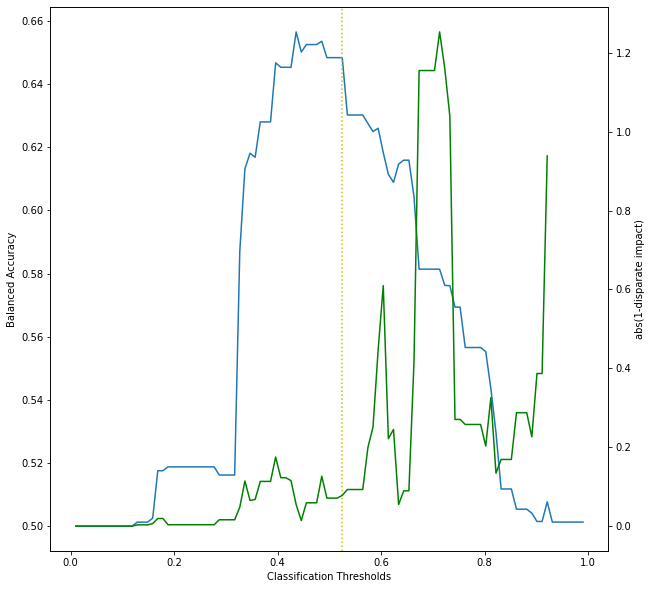

In [213]:
line_graph_accuracy_disparate_impact(class_thresh_array, transform_bal_acc_arr, np.abs(1.0-np.array(transform_disp_imp_arr)), best_thresh)

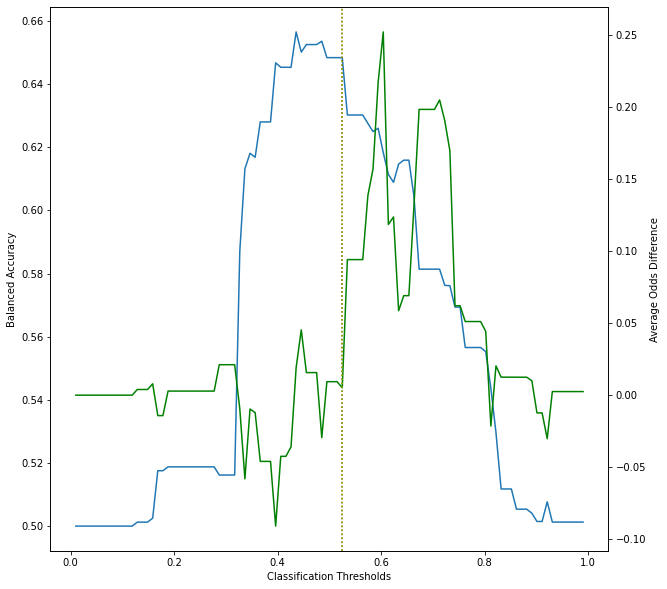

In [214]:
line_graph_accuracy_aod(class_thresh_array, transform_bal_acc_arr, transform_avg_odds_diff_arr, best_thresh)

In [215]:
def plot_comparison_graphs(X,y):

    plt.subplot(1, 2, 1)
    lst = [X['Statistical parity difference'],y['Statistical parity difference'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.ylim(-0.5,0.5)
    plt.title('Statistical parity difference')
    plt.subplot(1, 2, 2)
    lst=[X['Disparate impact'],y['Disparate impact'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.title('Disparate impact')
    plt.ylim(-0.5,2)
    plt.show()

    plt.subplot(1, 2, 1)
    lst=[X['Average odds difference'],y['Average odds difference'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.ylim(-0.5,0.5)
    plt.title('Average odds difference')
    plt.subplot(1, 2, 2)
    lst=[X['Equal opportunity difference'],y['Equal opportunity difference'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.title('Equal opportunity difference')
    plt.ylim(-0.5,0.25)
    plt.show()

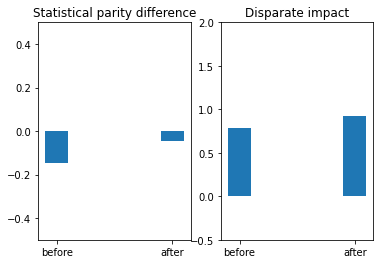

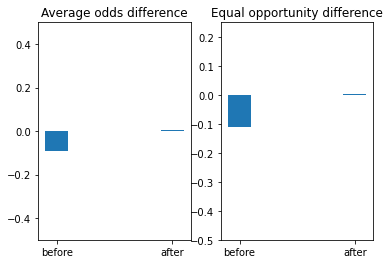

In [216]:
plot_comparison_graphs(before_metric, after_metric)